In [33]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from sklearn.neighbors import LocalOutlierFactor 
# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se

import warnings
warnings.filterwarnings('ignore')
import math
from itertools import product
from itertools import combinations
from tqdm import tqdm

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
df = pd.read_csv('../Datos/df_cluster_0.csv')
df_general = pd.read_csv('../Datos/Global_Superstore.csv', encoding='latin')
df.head()

,Customer Name,facturas_total,descuento_medio,compras_total,compras_media,beneficio_total,costo_envio_medio,cluster_ward
0,Aaron Bergman,89,0.110112,24644.62750,276.905927,4683.20800,35.149551,0
1,Aaron Hawkins,56,0.160929,20759.51384,370.705604,2450.92904,40.882321,0
2,Adam Bellavance,68,0.131765,20186.77840,296.864388,4979.97690,40.168971,0
3,Adam Hart,84,0.093238,21718.20142,258.550017,1902.03342,28.165714,0
4,Adrian Barton,77,0.209091,25123.18000,326.275065,6417.28450,34.263377,0


In [35]:
df_clusters = df[['Customer Name', 'cluster_ward']]

In [36]:
df_clusters.head()

,Customer Name,cluster_ward
0,Aaron Bergman,0
1,Aaron Hawkins,0
2,Adam Bellavance,0
3,Adam Hart,0
4,Adrian Barton,0


In [37]:
df_general.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [ ]:
df_combined = df_general.merge(df_clusters, on="Customer Name", how="left") #mergeo para poder aplicar el cluster indicado a los clientes

df_combined['cluster'] = df_combined['cluster_ward'].fillna(1).astype(int)
# al tener 2 clusters, los que son 0 se colocan y los demás los paso a 1
df_combined.drop(columns=['cluster_ward'], inplace=True)


In [39]:
df_combined.shape

(51290, 25)

In [ ]:
df_combined_0 = df_combined[df_combined['cluster'] ==  0].reset_index(drop=True)
df_combined_1 = df_combined[df_combined['cluster'] ==  1].reset_index(drop=True)
# divido mi data frame en los 2 para poder trabajarlos de manera independiente

In [41]:
df_combined_0.shape

(20567, 25)

In [42]:
df_combined_1.shape

(30723, 25)

In [43]:
df_combined_1.to_csv('../Datos/df_predecir_1.csv')

In [44]:
df_combined_0.to_csv('../Datos/df_predecir_0.csv')

In [45]:
df_combined_0.drop(columns='cluster', inplace=True)

# Explorar mi data frame

In [46]:
df_combined_0.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.971,915.49,Medium
1,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.540,910.16,Medium
2,22732,IN-2013-42360,28-06-2013,01-07-2013,Second Class,JM-15655,Jim Mitchum,Corporate,Sydney,New South Wales,Australia,NaN,APAC,Oceania,TEC-PH-10000030,Technology,Phones,"Samsung Smart Phone, with Caller ID",2862.675,5,0.1,763.275,897.35,Critical
3,30570,IN-2011-81826,07-11-2011,09-11-2011,First Class,TS-21340,Toby Swindell,Consumer,Porirua,Wellington,New Zealand,NaN,APAC,Oceania,FUR-CH-10004050,Furniture,Chairs,"Novimex Executive Leather Armchair, Adjustable",1822.080,4,0.0,564.840,894.77,Critical
4,40155,CA-2014-135909,14-10-2014,21-10-2014,Standard Class,JW-15220,Jane Waco,Corporate,Sacramento,California,United States,95823.0,US,West,OFF-BI-10003527,Office Supplies,Binders,Fellowes PB500 Electric Punch Plastic Comb Bin...,5083.960,5,0.2,1906.485,867.69,Low


In [47]:
df_combined_0.drop(columns=['State', 'Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'City', 'Country', 'Postal Code', 'Region', 'Product ID', 'Product Name', 'Profit', 'Customer Name'], inplace=True)

Me cargo estas columnas porque no son tan importantes en mi primera observación

In [48]:
f.exploracion_dataframe(df_combined_0, 'Sales')

El número de datos es 20567 y el de columnas es 10

 ..................... 

Los duplicados que tenemos en el conjunto de datos son: 2

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
Ship Mode,object
Segment,object
Market,object
Category,object
Sub-Category,object
Sales,float64
Quantity,int64
Discount,float64
Shipping Cost,float64
Order Priority,object



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna Ship Mode tiene los siguientes valores únicos:


,count
Ship Mode,
Standard Class,12359
Second Class,4017
First Class,3094
Same Day,1097


La columna Segment tiene los siguientes valores únicos:


,count
Segment,
Consumer,10892
Corporate,6218
Home Office,3457


La columna Market tiene los siguientes valores únicos:


,count
Market,
APAC,4621
EU,4114
LATAM,4053
US,3974
Africa,1859
EMEA,1802
Canada,144


La columna Category tiene los siguientes valores únicos:


,count
Category,
Office Supplies,12293
Technology,4201
Furniture,4073


La columna Sub-Category tiene los siguientes valores únicos:


,count
Sub-Category,
Binders,2377
Storage,2062
Art,1859
Chairs,1437
Phones,1395
Paper,1368
Furnishings,1248
Accessories,1225
Bookcases,1007


La columna Order Priority tiene los siguientes valores únicos:


,count
Order Priority,
Medium,11734
High,6144
Critical,1624
Low,1065


- Tengo 20567 filas, con 10 columnas de información de cada compra

In [49]:
df_combined_0.head()

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Quantity,Discount,Shipping Cost,Order Priority
0,First Class,Consumer,APAC,Technology,Phones,5175.171,9,0.1,915.49,Medium
1,First Class,Home Office,EU,Technology,Phones,2892.510,5,0.1,910.16,Medium
2,Second Class,Corporate,APAC,Technology,Phones,2862.675,5,0.1,897.35,Critical
3,First Class,Consumer,APAC,Furniture,Chairs,1822.080,4,0.0,894.77,Critical
4,Standard Class,Corporate,US,Office Supplies,Binders,5083.960,5,0.2,867.69,Low


In [50]:
df_combined_0['Discount'] = pd.to_numeric(df_combined_0['Discount'], errors='coerce')

df_combined_0['Discount_Category'] = pd.cut(
    df_combined_0['Discount'],
    bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
    labels=['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']  # Nombres de las categorías
)

df_combined_0['Quantity_Group'] = pd.cut(
    df_combined_0['Quantity'],
    bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
    labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
)

df_combined_0.drop(columns=['Quantity', 'Discount'], inplace=True)

Convierto estas columnas a categóricas, ya que sus valores son muy particulares y puede ser más simple simplificarlos en distintas categorías.

In [51]:
df_combined_0.head()

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
0,First Class,Consumer,APAC,Technology,Phones,5175.171,915.49,Medium,< 0.25,6 - 10
1,First Class,Home Office,EU,Technology,Phones,2892.510,910.16,Medium,< 0.25,<= 5
2,Second Class,Corporate,APAC,Technology,Phones,2862.675,897.35,Critical,< 0.25,<= 5
3,First Class,Consumer,APAC,Furniture,Chairs,1822.080,894.77,Critical,< 0.25,<= 5
4,Standard Class,Corporate,US,Office Supplies,Binders,5083.960,867.69,Low,< 0.25,<= 5


In [52]:
preprocesar = sc.Exploracion(df_combined_0)
preprocesar.explorar_datos()

5 registros aleatorios:


,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
12147,Standard Class,Consumer,APAC,Office Supplies,Storage,96.8112,5.87,Medium,< 0.25,<= 5
12580,First Class,Consumer,APAC,Office Supplies,Art,113.2452,5.34,High,< 0.25,<= 5
14697,Second Class,Corporate,US,Office Supplies,Binders,27.9360,3.34,High,< 0.25,<= 5
9768,Standard Class,Consumer,Africa,Furniture,Furnishings,113.2800,9.51,Medium,< 0.25,<= 5
14452,Standard Class,Home Office,LATAM,Office Supplies,Paper,59.5200,3.53,Medium,< 0.25,<= 5




Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20567 entries, 0 to 20566
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Ship Mode          20567 non-null  object  
 1   Segment            20567 non-null  object  
 2   Market             20567 non-null  object  
 3   Category           20567 non-null  object  
 4   Sub-Category       20567 non-null  object  
 5   Sales              20567 non-null  float64 
 6   Shipping Cost      20567 non-null  float64 
 7   Order Priority     20567 non-null  object  
 8   Discount_Category  20567 non-null  category
 9   Quantity_Group     20567 non-null  category
dtypes: category(2), float64(2), object(6)
memory usage: 1.3+ MB
None


Duplicados en el DataFrame:
2


Estadísticas descriptivas de las columnas numéricas:


,count,mean,std,min,25%,50%,75%,max
Sales,20567.0,290.949976,611.266038,0.444,32.400,93.7236,283.86,22638.48
Shipping Cost,20567.0,30.516571,66.460836,0.000,2.795,8.5200,27.71,915.49




Estadísticas descriptivas de las columnas categóricas:


,count,unique,top,freq
Ship Mode,20567,4,Standard Class,12359
Segment,20567,3,Consumer,10892
Market,20567,7,APAC,4621
Category,20567,3,Office Supplies,12293
Sub-Category,20567,17,Binders,2377
Order Priority,20567,4,Medium,11734




Número de valores nulos por columna:
Ship Mode            0
Segment              0
Market               0
Category             0
Sub-Category         0
Sales                0
Shipping Cost        0
Order Priority       0
Discount_Category    0
Quantity_Group       0
dtype: int64


Distribución de valores categóricos:

Columna: Ship Mode
Ship Mode
Standard Class    12359
Second Class       4017
First Class        3094
Same Day           1097
Name: count, dtype: int64

Columna: Segment
Segment
Consumer       10892
Corporate       6218
Home Office     3457
Name: count, dtype: int64

Columna: Market
Market
APAC      4621
EU        4114
LATAM     4053
US        3974
Africa    1859
EMEA      1802
Canada     144
Name: count, dtype: int64

Columna: Category
Category
Office Supplies    12293
Technology          4201
Furniture           4073
Name: count, dtype: int64

Columna: Sub-Category
Sub-Category
Binders        2377
Storage        2062
Art            1859
Chairs         1437
Phones      

,Sales,Shipping Cost
Sales,1.000000,0.744748
Shipping Cost,0.744748,1.000000


In [53]:
preprocesar_cluster = sc.Exploracion(df_combined_0)

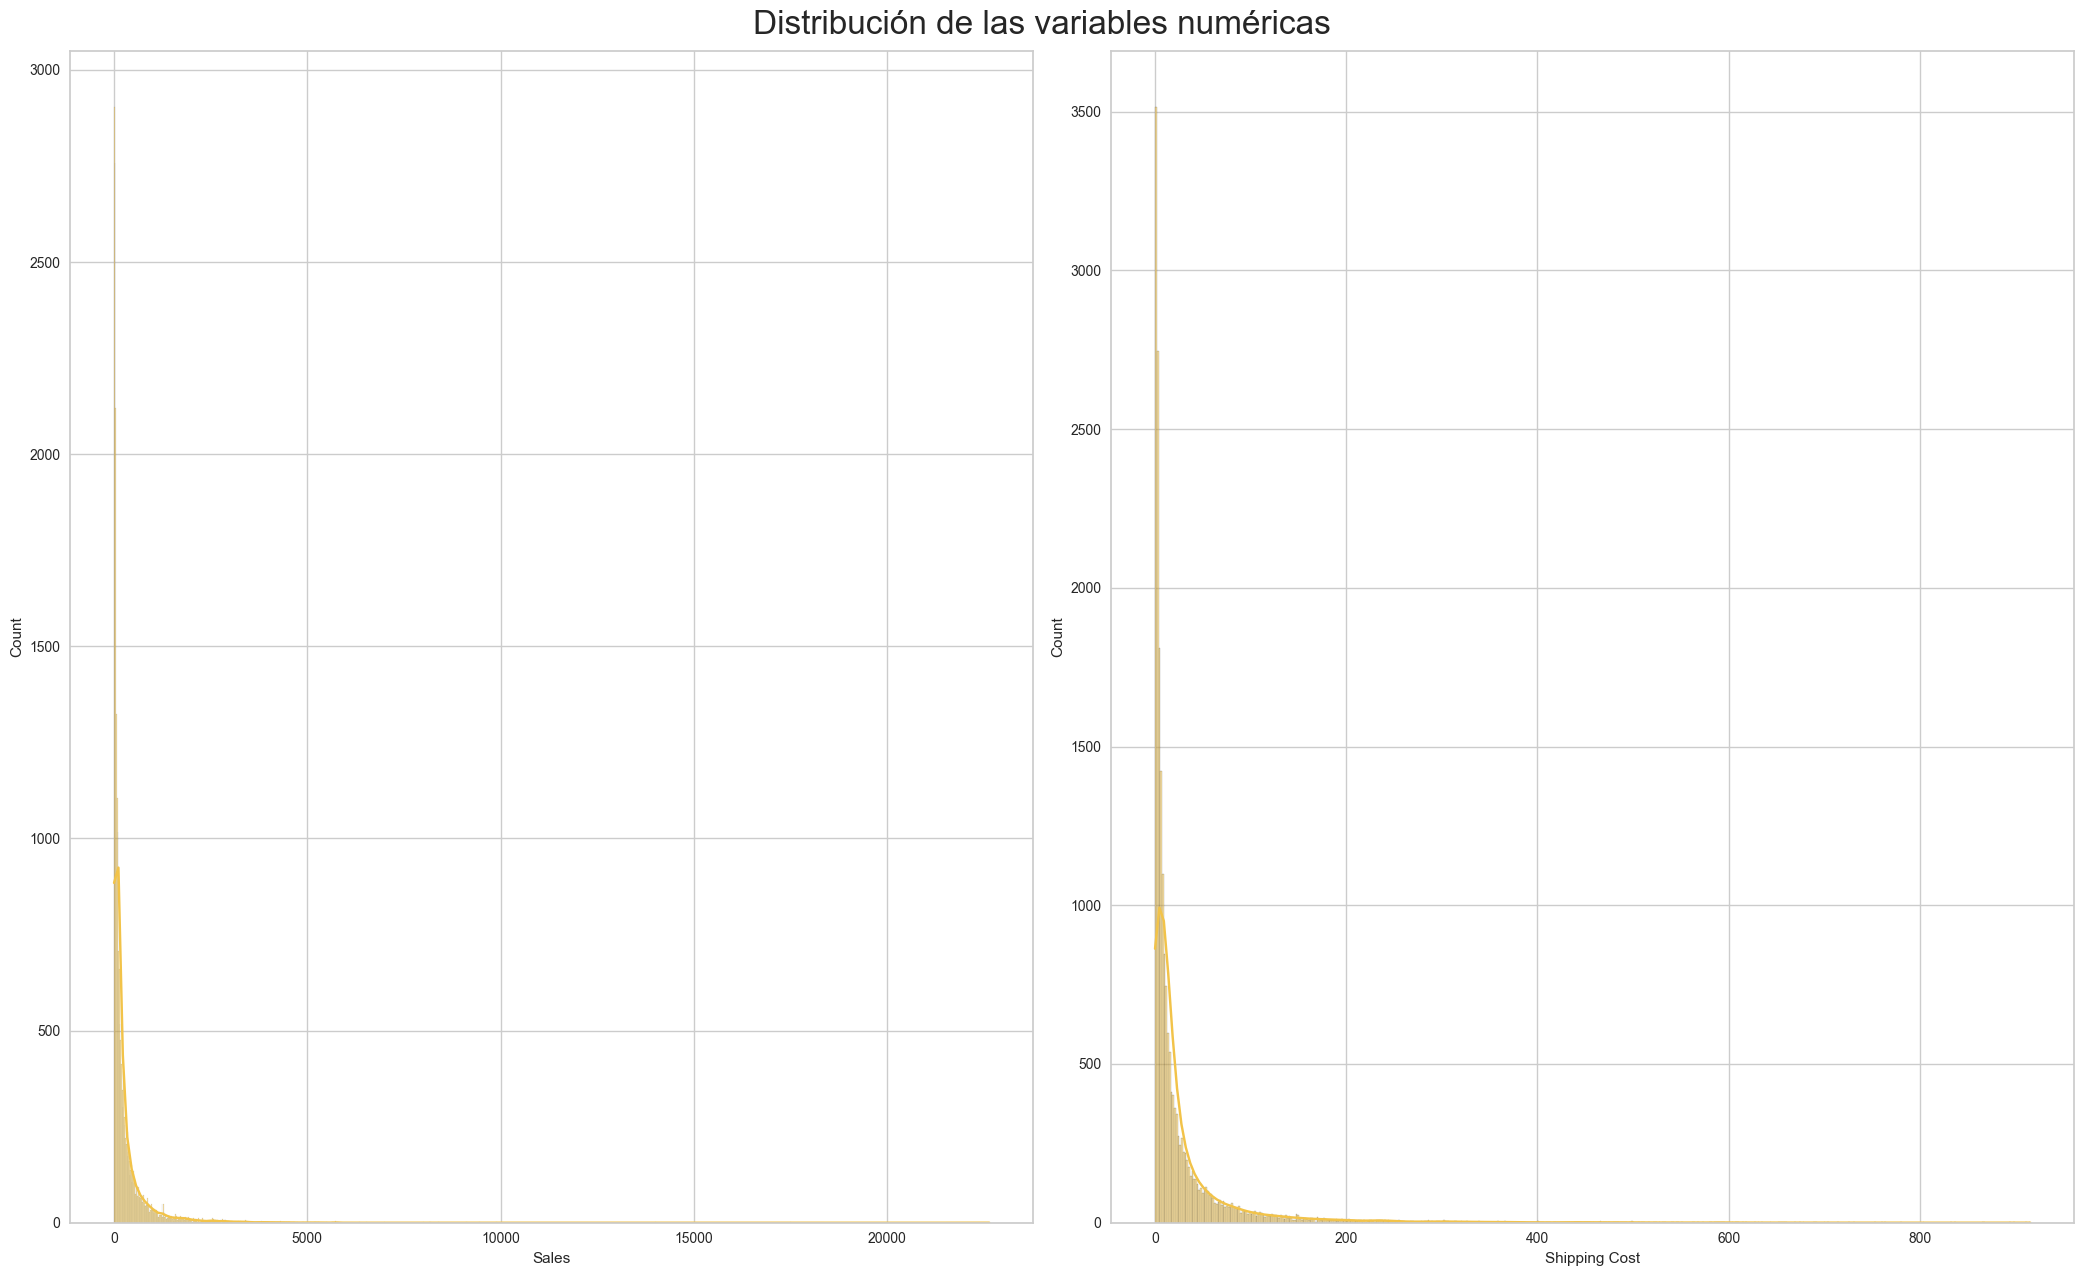

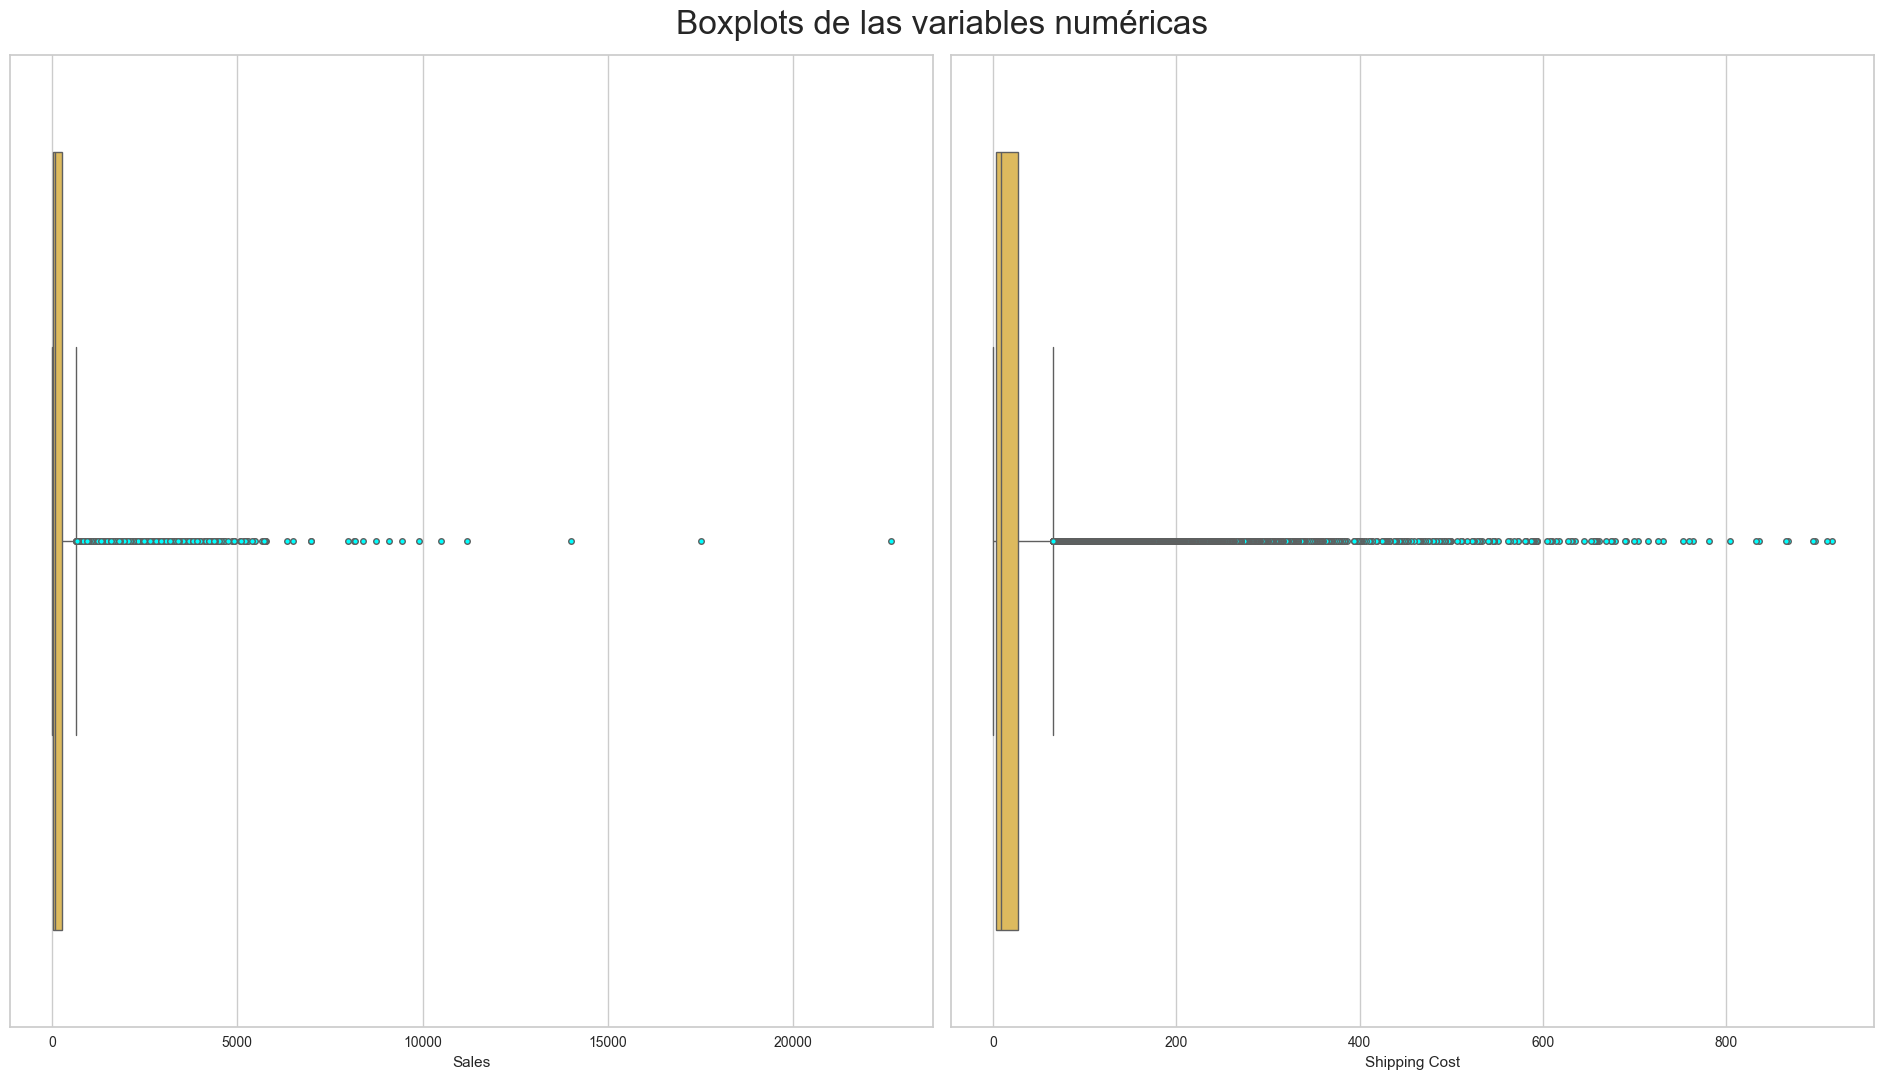

In [54]:
preprocesar_cluster.visualizar_numericas()

Tengo una distribución muy extraña en las variables numéricas que he mantenido. Esto a simple vista puede causar ruido pero hay que considerar que todas estas filas de datos corresponden al desglose completo de unas facturas por lo que algunas pueden ser muy distantes de las otras si las vemos de manera particular y no como parte de un conjunto.

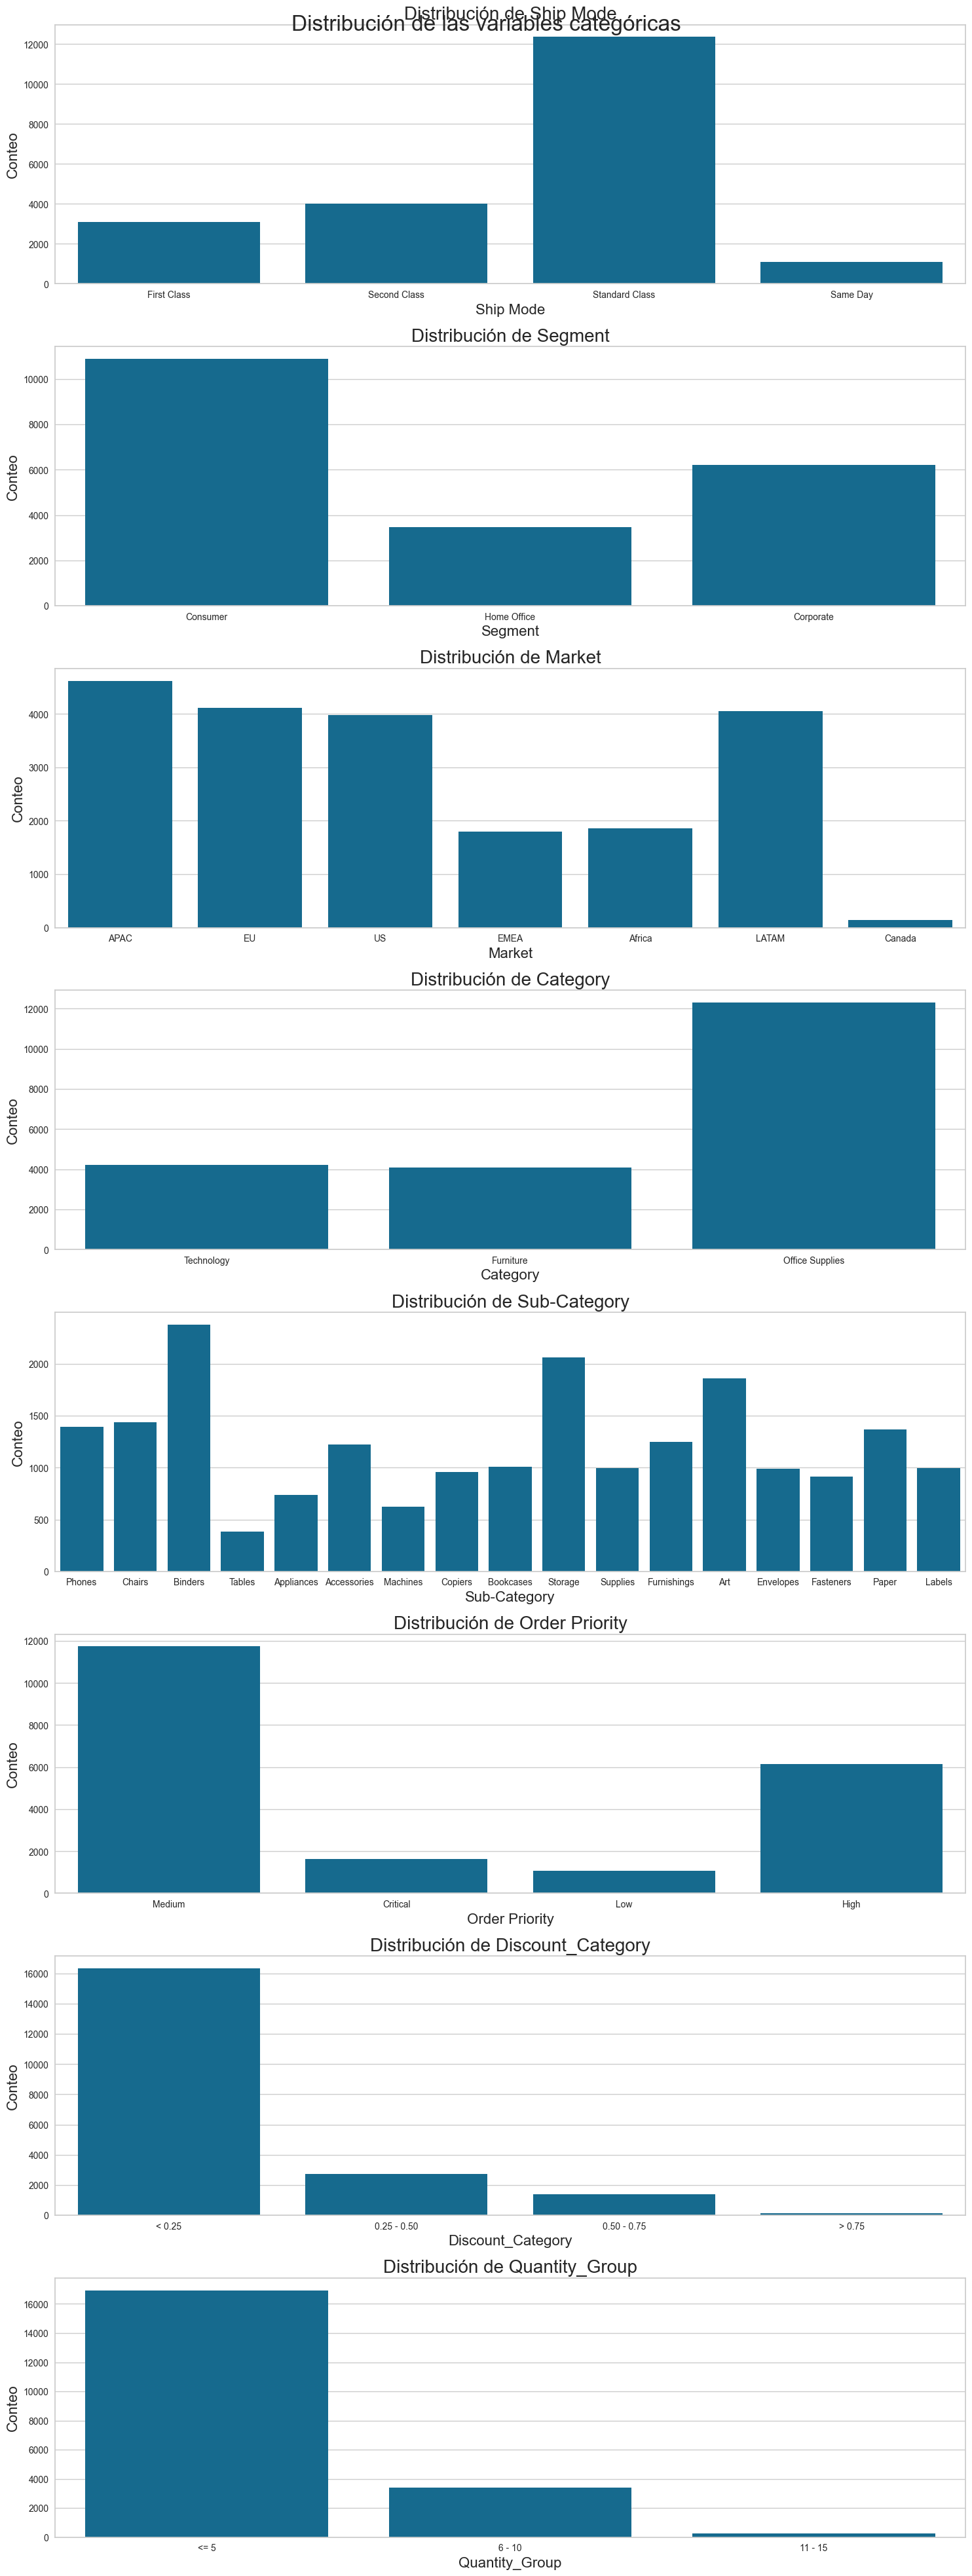

In [ ]:
preprocesar_cluster.visualizar_categoricas()

## Outliers

In [56]:
df_combined_0[df_combined_0['Sales'] > 10000]

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
176,Standard Class,Consumer,US,Technology,Copiers,10499.970,363.19,Medium,< 0.25,<= 5
195,Standard Class,Corporate,US,Technology,Copiers,17499.950,349.07,Medium,< 0.25,<= 5
3383,First Class,Home Office,US,Technology,Copiers,11199.968,45.98,High,< 0.25,<= 5
5634,Standard Class,Home Office,US,Technology,Machines,22638.480,24.29,Medium,0.25 - 0.50,6 - 10
6426,First Class,Consumer,US,Technology,Copiers,13999.960,20.00,Medium,< 0.25,<= 5


<Axes: xlabel='Sales', ylabel='Shipping Cost'>

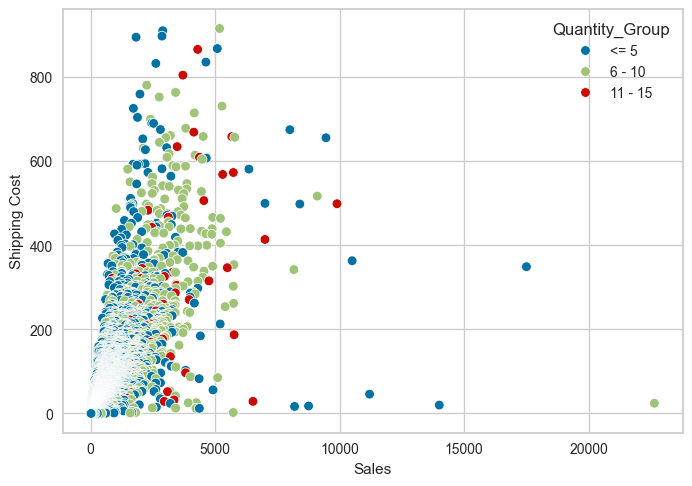

In [ ]:
sns.scatterplot(x='Sales', y='Shipping Cost', data=df_combined_0, hue='Quantity_Group')

Aquí puedo visualizar la distribución de cómo interactúan mis dos variables numéricas. Estas tienen una relación importante, a la vez tiene algunos elementos sin mucho sentido. Para este modelo, no elimino outliers para ver cómo interactúan estos en mi modelo.

## Estandarizar

In [58]:
lista_num = df_combined_0.select_dtypes(include=['int64', 'float64']).columns.tolist() # saco mis columnas numéricas

if 'Sales' in lista_num:
    lista_num.remove('Sales')

In [59]:
f.escalar_columnas_metodo(df_combined_0, lista_num, 'robust')

,Ship Mode,Segment,Market,Category,Sub-Category,Sales,Shipping Cost,Order Priority,Discount_Category,Quantity_Group
0,First Class,Consumer,APAC,Technology,Phones,5175.171,36.402569,Medium,< 0.25,6 - 10
1,First Class,Home Office,EU,Technology,Phones,2892.510,36.188641,Medium,< 0.25,<= 5
2,Second Class,Corporate,APAC,Technology,Phones,2862.675,35.674493,Critical,< 0.25,<= 5
3,First Class,Consumer,APAC,Furniture,Chairs,1822.080,35.570941,Critical,< 0.25,<= 5
4,Standard Class,Corporate,US,Office Supplies,Binders,5083.960,34.484046,Low,< 0.25,<= 5
...,...,...,...,...,...,...,...,...,...,...
20562,First Class,Home Office,LATAM,Office Supplies,Paper,18.640,-0.341561,Medium,< 0.25,<= 5
20563,Same Day,Corporate,APAC,Office Supplies,Paper,26.940,-0.341561,High,< 0.25,<= 5
20564,Standard Class,Consumer,US,Office Supplies,Appliances,0.444,-0.341561,Medium,> 0.75,<= 5
20565,Same Day,Home Office,US,Office Supplies,Envelopes,22.920,-0.341561,High,< 0.25,<= 5


Uso el método Robust porque tengo muchos outliers y quiero mantenerlos.

## Encoding

In [60]:
lista_col_cat = df_combined_0.select_dtypes(include=['object', 'category'])

In [61]:
asunciones = se.Asunciones(dataframe=df_combined_0, columna_numerica='Sales')

for categoria in lista_col_cat:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = se.TestEstadisticos(df_combined_0, "Sales", categoria)
    test.run_all_tests()
    print("\n###########################\n")


Estamos analizando la variable SHIP MODE
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['First Class', 'Second Class', 'Standard Class', 'Same Day']

Realizando test de Kruskal...
Estadístico de prueba: 3.3511073437616696
Valor p: 0.3405925623314053
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-18.1497,0.8329,-73.3387,37.0393,First Class-Same Day
1,1.6124,0.9995,-35.9550,39.1798,First Class-Second Class
2,-2.3647,0.9975,-33.9374,29.2079,First Class-Standard Class
3,19.7621,0.7783,-33.7415,73.2657,Same Day-Second Class
4,15.7849,0.8452,-33.6939,65.2638,Same Day-Standard Class
5,-3.9771,0.9843,-32.5016,24.5474,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Home Office', 'Corporate']

Realizando test de Kruskal...
Estadístico de prueba: 1.840423575997225
Valor p: 0.39843464847138066
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,9.7151,0.5769,-13.0579,32.4881,Consumer-Corporate
1,2.4589,0.9769,-25.5104,30.4282,Consumer-Home Office
2,-7.2562,0.8416,-37.6528,23.1404,Corporate-Home Office



###########################

Estamos analizando la variable MARKET
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Market las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['APAC', 'EU', 'US', 'EMEA', 'Africa', 'LATAM', 'Canada']

Realizando test de Kruskal...
Estadístico de prueba: 1044.421547033699
Valor p: 2.203269477409355e-222
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-200.1614,0.0000,-249.3294,-150.9933,APAC-Africa
1,-176.2327,0.0108,-327.7232,-24.7422,APAC-Canada
2,-193.5427,0.0000,-243.2622,-143.8232,APAC-EMEA
3,-60.8024,0.0001,-99.1762,-22.4287,APAC-EU
4,-166.2289,0.0000,-204.7551,-127.7027,APAC-LATAM
5,-93.4375,0.0000,-132.1672,-54.7078,APAC-US
6,23.9287,0.9993,-130.9254,178.7828,Africa-Canada
7,6.6187,0.9999,-52.5628,65.8002,Africa-EMEA
8,139.3589,0.0000,89.3293,189.3886,Africa-EU
9,33.9324,0.4176,-16.2143,84.0791,Africa-LATAM



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Furniture', 'Office Supplies']

Realizando test de Kruskal...
Estadístico de prueba: 6027.55775508947
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-338.6123,0.0,-363.2787,-313.9459,Furniture-Office Supplies
1,76.5646,0.0,46.5630,106.5663,Furniture-Technology
2,415.1769,0.0,390.7944,439.5594,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Phones', 'Chairs', 'Binders', 'Tables', 'Appliances', 'Accessories', 'Machines', 'Copiers', 'Bookcases', 'Storage', 'Supplies', 'Furnishings', 'Art', 'Envelopes', 'Fasteners', 'Paper', 'Labels']

Realizando test de Kruskal...
Estadístico de prueba: 10252.501616569542
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,427.1203,0.0,338.4987,515.7418,Accessories-Appliances
1,-199.5179,0.0,-269.4765,-129.5593,Accessories-Art
2,-182.9019,0.0,-249.7641,-116.0397,Accessories-Binders
3,386.3314,0.0,305.4673,467.1956,Accessories-Bookcases
4,228.5462,0.0,154.6198,302.4725,Accessories-Chairs
...,...,...,...,...,...
131,-494.2396,0.0,-573.1705,-415.3087,Phones-Supplies
132,434.7136,0.0,324.8223,544.6050,Phones-Tables
133,-126.2007,0.0,-199.6315,-52.7699,Storage-Supplies
134,802.7525,0.0,696.7426,908.7625,Storage-Tables



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Medium', 'Critical', 'Low', 'High']

Realizando test de Kruskal...
Estadístico de prueba: 1.3433820117528967
Valor p: 0.7188582633955443
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,4.6798,0.9928,-39.1394,48.4991,Critical-High
1,-24.7950,0.7326,-86.7186,37.1286,Critical-Low
2,10.8498,0.9083,-30.7301,52.4297,Critical-Medium
3,-29.4749,0.4664,-81.6022,22.6525,High-Low
4,6.1699,0.9187,-18.5609,30.9008,High-Medium
5,35.6448,0.2628,-14.6148,85.9044,Low-Medium



###########################

Estamos analizando la variable DISCOUNT_CATEGORY
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Discount_Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['< 0.25', '0.25 - 0.50', '0.50 - 0.75', '> 0.75']

Realizando test de Kruskal...
Estadístico de prueba: 983.8231515462476
Valor p: 5.812412157036999e-213
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-149.8914,0.0000,-201.4559,-98.3270,0.25 - 0.50-0.50 - 0.75
1,67.3691,0.0000,35.0932,99.6450,0.25 - 0.50-< 0.25
2,-194.0130,0.0045,-342.8070,-45.2189,0.25 - 0.50-> 0.75
3,217.2605,0.0000,173.4836,261.0375,0.50 - 0.75-< 0.25
4,-44.1215,0.8779,-195.8264,107.5834,0.50 - 0.75-> 0.75
5,-261.3820,0.0000,-407.6599,-115.1042,< 0.25-> 0.75



###########################

Estamos analizando la variable QUANTITY_GROUP
Para la columna Sales, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Quantity_Group las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['6 - 10', '<= 5', '11 - 15']

Realizando test de Kruskal...
Estadístico de prueba: 1689.5031386565245
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-373.8331,0.0,-463.6834,-283.9829,11 - 15-6 - 10
1,-761.4940,0.0,-848.7948,-674.1932,11 - 15-<= 5
2,-387.6609,0.0,-413.6783,-361.6435,6 - 10-<= 5



###########################



Resultados de buscar las diferencias entre mis columnas categóricas:
- Ship Mode: no hay orden.
- Segment: no hay orden.
- Market: hay orden.
- Category: hay orden.
- Sub-Category: hay orden.
- Order Priority: no hay orden
- Discount_Category: hay orden.
- Quantity_Group: hay orden.

In [ ]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment', 'Order Priority'], 
                        "dummies": [], 
                        'ordinal' : {},
                        "label": [] , 
                        "frequency": [],
                        "target": ["Market", "Category", "Sub-Category", "Discount_Category", "Quantity_Group"]
                        }

In [63]:
encoding = se.Encoding(df_combined_0, diccionario_encoding, "Sales")
df_encode = encoding.one_hot_encoding()
df_encode = encoding.target_encoding()
df_encode.head()

,Ship Mode,Segment,Sales,Shipping Cost,Order Priority,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,First Class,Consumer,5175.171,36.402569,Medium,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,388.376416,547.018128,618.799551,315.400165,609.607347
1,First Class,Home Office,2892.510,36.188641,Medium,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,325.114659,551.240787,592.774328,317.592607,219.059908
2,Second Class,Corporate,2862.675,35.674493,Critical,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386.588755,557.301946,599.827583,315.266028,215.647828
3,First Class,Consumer,1822.080,35.570941,Critical,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,399.982921,484.398507,504.014715,318.889702,219.976199
4,Standard Class,Corporate,5083.960,34.484046,Low,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,288.915258,141.579897,97.821329,315.400165,215.979321


In [64]:
df_encode.drop(columns=['Ship Mode', 'Segment', 'Order Priority'], inplace=True)

In [65]:
df_encode.head()

,Sales,Shipping Cost,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,5175.171,36.402569,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,388.376416,547.018128,618.799551,315.400165,609.607347
1,2892.510,36.188641,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,325.114659,551.240787,592.774328,317.592607,219.059908
2,2862.675,35.674493,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386.588755,557.301946,599.827583,315.266028,215.647828
3,1822.080,35.570941,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,399.982921,484.398507,504.014715,318.889702,219.976199
4,5083.960,34.484046,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,288.915258,141.579897,97.821329,315.400165,215.979321


In [66]:
df_encode.shape

(20567, 18)

In [ ]:
df_encode.to_csv('../../Datos/Datos_Modelo_1/Modelo_1_CL_0.csv')